In [ ]:
!pip install pytesseract
!pip install networkx
!pip install matplotlib
!pip install pdf2image
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 0s (743 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pytesseract
from sklearn.cluster import KMeans
from pdf2image import convert_from_path


In [ ]:
#Defining Path
image_path = "/content/FloorPlan.pdf"  # Upload your floorplan image

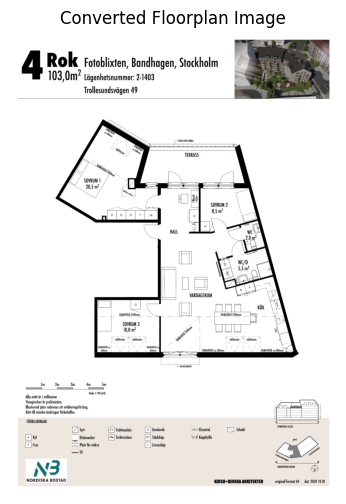

In [ ]:
def convert_pdf_to_image(pdf_path):
    images = convert_from_path(pdf_path)
    image_path = "floorplan.jpg"  # Save the first page as a JPG
    images[0].save(image_path, 'JPEG')

    # Display the image using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(images[0], cmap='gray')
    plt.axis("off")
    plt.title("Converted Floorplan Image")
    plt.show()

    return image_path

# Define PDF path
pdf_path = "/content/FloorPlan.pdf"  # Update the path based on your upload location

# Convert PDF to image and display it
image_path = convert_pdf_to_image(pdf_path)

In [ ]:
# Function to preprocess the image
def preprocess_image(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)
    return edged


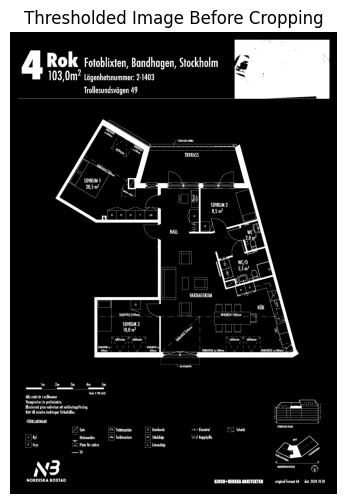

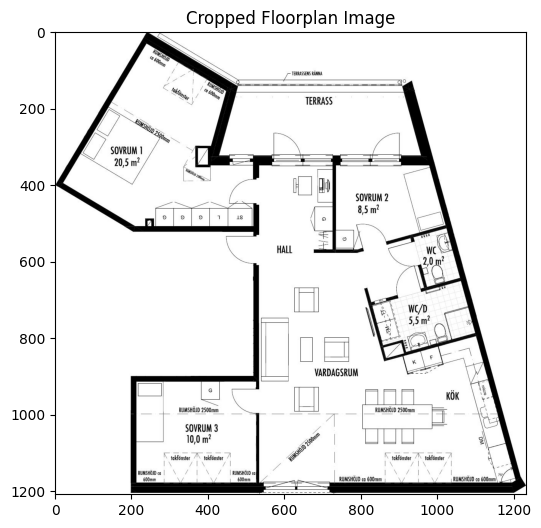

In [ ]:
# Function to crop main content area and display it
def crop_main_content(image):
    if image is None:
        print("⚠️ Error: Image not loaded correctly!")
        return None

    # Apply binary thresholding
    _, thresh = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)

    # Show the thresholded image to check contours
    plt.figure(figsize=(10, 6))
    plt.imshow(thresh, cmap='gray')
    plt.axis("off")
    plt.title("Thresholded Image Before Cropping")
    plt.show()

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        print("⚠️ Warning: No contours detected. Cropping failed.")
        return image  # Return the original image as fallback

    # Get image dimensions
    img_h, img_w = image.shape[:2]
    img_area = img_h * img_w

    # Filter out large border-like contours
    valid_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        contour_area = w * h

        # Ignore contours that are close to full image size (likely frame)
        if contour_area > 0.9 * img_area:
            continue

        # Ignore very small noise contours
        if contour_area < 0.001 * img_area:
            continue

        # Keep valid contours
        valid_contours.append(contour)

    if not valid_contours:
        print("⚠️ Warning: No valid floorplan contours detected.")
        return image

    # Select the largest valid contour (assumed to be the floorplan)
    max_contour = max(valid_contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(max_contour)

    # Crop the image based on the largest valid contour
    cropped_image = image[y:y+h, x:x+w]

    # Display the cropped image
    plt.figure(figsize=(10, 6))
    plt.imshow(cropped_image, cmap='gray')
    plt.axis("on")
    plt.title("Cropped Floorplan Image")
    plt.show()

    return cropped_image

# Load the image
image_path = "floorplan.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply cropping function
cropped_image = crop_main_content(image)

In [ ]:
# Function to crop main content area
def crop_main_content(image):
    _, thresh = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)
    cropped_image = image[y:y+h, x:x+w]

    # Display the cropped image
    plt.figure(figsize=(10, 6))
    plt.imshow(cropped_image, cmap='gray')
    plt.axis("off")
    plt.title("Cropped Floorplan Image")
    plt.show()

    return cropped_image

In [ ]:
# Function to isolate walls and detect corner points
def detect_walls_and_corners(cropped_image):
    if cropped_image is None:
        print("⚠️ Error: Cropped image is None!")
        return []

    # Convert to binary image (ensure white walls, black background)
    _, binary = cv2.threshold(cropped_image, 200, 255, cv2.THRESH_BINARY_INV)

    # Apply morphological operations to refine walls
    kernel = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(binary, kernel, iterations=2)
    restored = cv2.dilate(eroded, kernel, iterations=2)  # Adjust if needed

    # Display the eroded and restored walls for debugging
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(eroded, cmap='gray')
    plt.axis("off")
    plt.title("Eroded Walls")

    plt.subplot(1, 2, 2)
    plt.imshow(restored, cmap='gray')
    plt.axis("off")
    plt.title("Restored Walls (After Dilation)")

    plt.show()


In [ ]:
 # Apply morphological operations to refine walls
_, binary = cv2.threshold(cropped_image, 200, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((5, 5), np.uint8)
eroded = cv2.erode(binary, kernel, iterations=1)

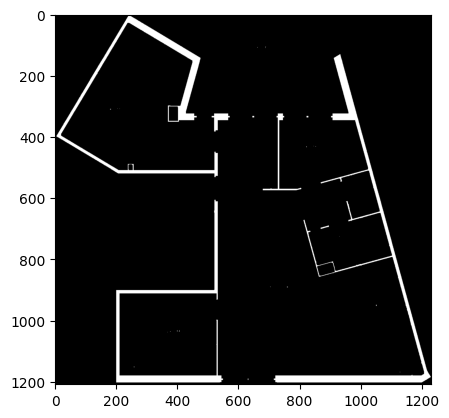

In [ ]:
plt.imshow(eroded, cmap='gray')

In [ ]:
# Detect corners using Shi-Tomasi instead of Harris (more stable for walls)
corners = cv2.goodFeaturesToTrack(eroded, maxCorners=100, qualityLevel=0.01, minDistance=10)

# Convert corners to integer format
if corners is None:
    print("⚠️ Warning: No corners detected!")
    corners = []
else:
    corners = np.int0(corners)

# Draw detected corners
corner_image = cv2.cvtColor(eroded, cv2.COLOR_GRAY2BGR)
corner_coords = []

for i in corners:
    x, y = i.ravel()
    corner_coords.append((x, y))
    cv2.circle(corner_image, (x, y), 5, (0, 0, 255), -1)

<ipython-input-42-c47b73166408>:9: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


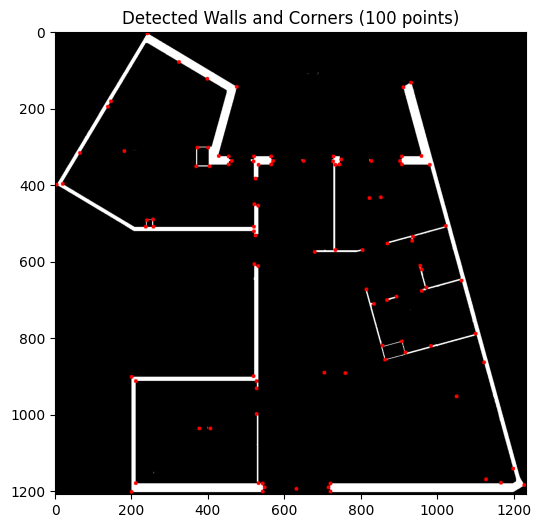

In [ ]:
# Display detected corners on eroded walls
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))  # Proper display
plt.axis("on")
plt.title(f"Detected Walls and Corners ({len(corner_coords)} points)")
plt.show()

i had to call the function again because I was having some issues with return

In [ ]:
def detect_walls_and_corners(cropped_image):
    corner_coords = []  # Store detected corners

    # Print detected corners
    print(f"Detected {len(corner_coords)} corner points.")
    for i, (x, y) in enumerate(corner_coords):
        print(f"Corner {i+1}: X={x}, Y={y}")

    return corner_coords  # Correctly indented inside the function

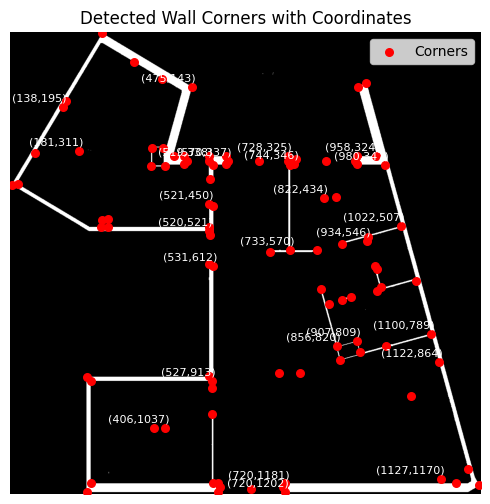

In [ ]:
# Display the detected corners on the eroded image with coordinate labels
plt.figure(figsize=(10, 6))
plt.imshow(eroded, cmap='gray')  # Show the eroded walls
plt.scatter(*zip(*corner_coords), color='red', s=30, label="Corners")  # Overlay detected points

# Adjust label positions to reduce overlap
offset_x, offset_y = 10, -10  # Offset text slightly from the points

for i, (x, y) in enumerate(corner_coords):
    if i % 4 == 0:  # Only label every 3rd point to reduce clutter
        plt.text(x + offset_x, y + offset_y, f"({x},{y})",
                 fontsize=8, color='white', ha='right', va='bottom')

plt.axis("off")
plt.title("Detected Wall Corners with Coordinates")
plt.legend()
plt.show()


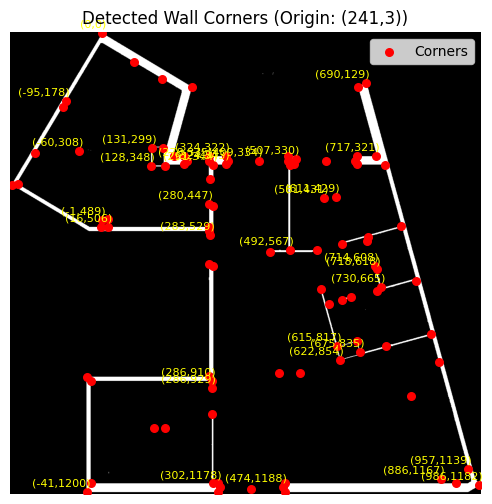

New Origin: (241,3)
Transformed Coordinates:
Corner 1: X=581, Y=431
Corner 2: X=286, Y=996
Corner 3: X=593, Y=708
Corner 4: X=622, Y=854
Corner 5: X=666, Y=806
Corner 6: X=573, Y=670
Corner 7: X=690, Y=129
Corner 8: X=652, Y=689
Corner 9: X=693, Y=543
Corner 10: X=286, Y=929
Corner 11: X=718, Y=674
Corner 12: X=518, Y=889
Corner 13: X=-60, Y=308
Corner 14: X=390, Y=1192
Corner 15: X=809, Y=950
Corner 16: X=-41, Y=1200
Corner 17: X=479, Y=1199
Corner 18: X=302, Y=1199
Corner 19: X=474, Y=1188
Corner 20: X=307, Y=1188
Corner 21: X=479, Y=1178
Corner 22: X=302, Y=1178
Corner 23: X=291, Y=1177
Corner 24: X=-30, Y=1177
Corner 25: X=286, Y=910
Corner 26: X=-30, Y=910
Corner 27: X=-41, Y=899
Corner 28: X=675, Y=835
Corner 29: X=859, Y=786
Corner 30: X=627, Y=698
Corner 31: X=730, Y=665
Corner 32: X=822, Y=647
Corner 33: X=290, Y=609
Corner 34: X=714, Y=608
Corner 35: X=280, Y=604
Corner 36: X=438, Y=572
Corner 37: X=492, Y=567
Corner 38: X=628, Y=550
Corner 39: X=695, Y=532
Corner 40: X=283, 

In [ ]:
# Select the new origin (example: choose the lowest Y and lowest X point)
origin_x, origin_y = min(corner_coords, key=lambda p: (p[1], p[0]))  # Bottom-left point

# Display the detected corners on the eroded image with coordinate labels
plt.figure(figsize=(10, 6))
plt.imshow(eroded, cmap='gray')  # Show the eroded walls
plt.scatter(*zip(*corner_coords), color='red', s=30, label="Corners")  # Overlay detected points

# Adjust label positions to reduce overlap
offset_x, offset_y = 10, -10  # Offset text slightly from the points

for i, (x, y) in enumerate(corner_coords):
    if i % 3 == 0:  # Only label every 3rd point to reduce clutter
        x_rel, y_rel = x - origin_x, y - origin_y  # Shift coordinates
        plt.text(x + offset_x, y + offset_y, f"({x_rel},{y_rel})",
                 fontsize=8, color='yellow', ha='right', va='bottom')

plt.axis("off")
plt.title(f"Detected Wall Corners (Origin: ({origin_x},{origin_y}))")
plt.legend()
plt.show()

# Print the transformed coordinates
print(f"New Origin: ({origin_x},{origin_y})")
print("Transformed Coordinates:")
for i, (x, y) in enumerate(corner_coords):
    x_rel, y_rel = x - origin_x, y - origin_y  # Shifted coordinates
    print(f"Corner {i+1}: X={x_rel}, Y={y_rel}")


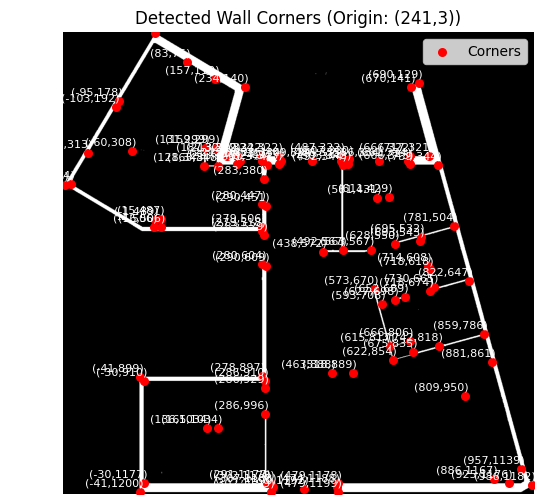

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(eroded, cmap='gray')  # Show the eroded walls
plt.scatter(*zip(*corner_coords), color='red', s=30, label="Corners")  # Overlay detected points

# Choose the new origin as the bottom-left corner (smallest Y and X)
origin_x, origin_y = min(corner_coords, key=lambda p: (p[1], p[0]))  # Bottom-left point

# Adjust label positions to reduce overlap
offset_x, offset_y = 10, -10  # Offset text slightly from the points

for x, y in corner_coords:
    x_rel, y_rel = x - origin_x, y - origin_y  # Shift coordinates
    plt.text(x + offset_x, y + offset_y, f"({x_rel},{y_rel})",
             fontsize=8, color='white', ha='right', va='bottom')

plt.axis("off")
plt.title(f"Detected Wall Corners (Origin: ({origin_x},{origin_y}))")
plt.legend()
plt.show()

filtering the results for better visualization

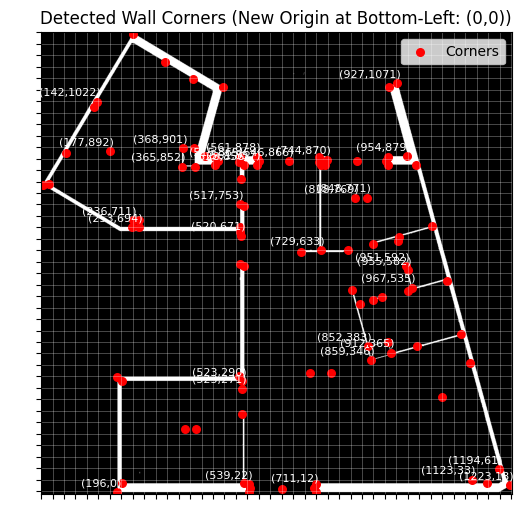

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(eroded, cmap='gray')  # Show the eroded walls
plt.scatter(*zip(*corner_coords), color='red', s=30, label="Corners")  # Overlay detected points

# Force the new origin to be the absolute bottom-left corner
origin_x = min(x for x, y in corner_coords)  # Leftmost X
origin_y = max(y for x, y in corner_coords)  # Bottom-most Y (since image Y increases downward)

# Adjust label positions to reduce overlap
offset_x, offset_y = 10, -10  # Offset text slightly from the points

for i, (x, y) in enumerate(corner_coords):
    if i % 3 == 0:  # Only label every 3rd point to reduce clutter
        x_rel, y_rel = x - origin_x, origin_y - y  # Shift coordinates and invert Y
        plt.text(x + offset_x, y + offset_y, f"({x_rel},{y_rel})",
                 fontsize=8, color='white', ha='right', va='bottom')

plt.grid(color='white', linestyle='-', linewidth=0.5, alpha=0.4)
plt.xticks(np.arange(0, eroded.shape[1], step=30), fontsize=6, color='white')  # Adjust step size for grid density
plt.yticks(np.arange(0, eroded.shape[0], step=30), fontsize=6, color='white')
plt.axis("on")
plt.title(f"Detected Wall Corners (New Origin at Bottom-Left: (0,0))")
plt.legend()
plt.show()

In [ ]:
def main(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cropped_image = crop_main_content(image)
    wall_corners = detect_walls_and_corners(cropped_image)  # Ensure this returns a value

    if not wall_corners:
        print("⚠️ No wall corners detected!")
        return [], None  # Return empty values if nothing is found
